In [329]:
# Final consistent labels:
# 0  -> background
# 1  -> brain
# 2  -> colon
# 3  -> heart
# 4  -> kidney
# 5  -> liver
# 6  -> lung
# 7  -> pancreas
# 8  -> small bowel
# 9  -> spleen
# 10 -> urinary bladder
# 11 -> lesion

In [221]:
from monai import data, transforms

In [224]:
image_loader = transforms.LoadImage(image_only=True)
CT = image_loader("CT2-res.nii.gz")

In [225]:
Mask = image_loader("Seg2.seg_aligned.nii.gz")

In [226]:
Mask.shape

torch.Size([512, 512, 457])

In [227]:
CT.shape

torch.Size([168, 168, 381])

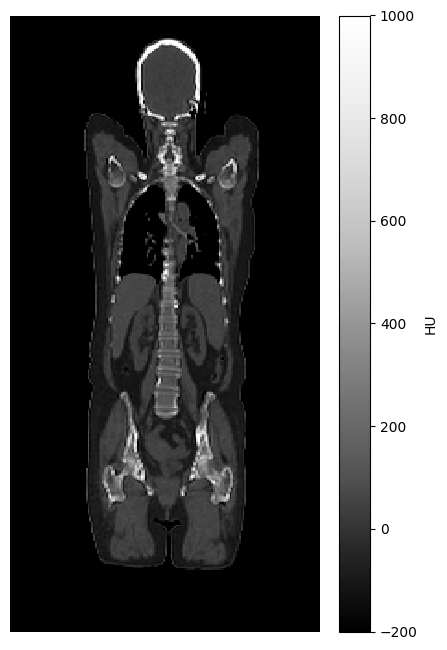

In [29]:
import matplotlib.pyplot as plt

CT_coronal_slice = CT[:, 100, :].cpu().numpy()

plt.figure(figsize=(5, 8))
plt.pcolormesh(CT_coronal_slice.T, cmap="Greys_r")
plt.colorbar(label="HU")
plt.axis('off')
plt.show()

In [30]:
channel_transform = transforms.EnsureChannelFirst()
CT_channel_transformed = channel_transform(CT)
CT_channel_transformed.shape

torch.Size([1, 168, 168, 381])

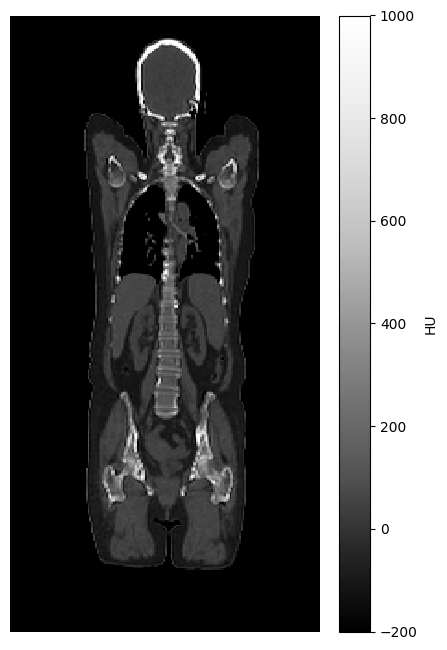

In [37]:
CT_coronal_slice = CT_channel_transformed[0, :, 100, :].cpu().numpy()

plt.figure(figsize=(5, 8))
plt.pcolormesh(CT_coronal_slice.T, cmap="Greys_r")
plt.colorbar(label="HU")
plt.axis('off')
plt.show()

In [56]:
orientation_transform = transforms.Orientation(axcodes="RAS")
CT_orientation_transformed = orientation_transform(CT_channel_transformed)

In [57]:
CT_orientation_transformed.shape

torch.Size([1, 168, 168, 381])

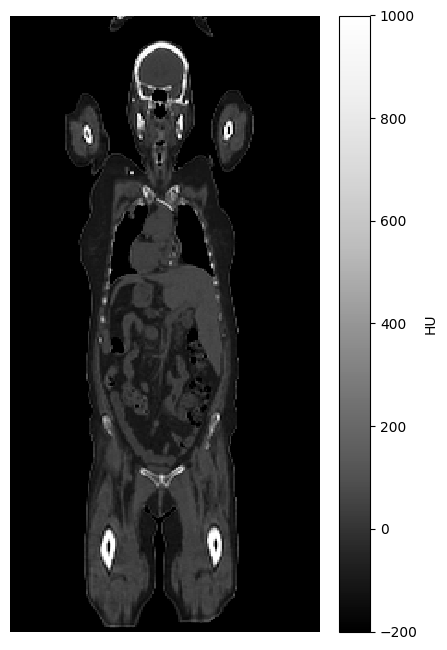

In [58]:
CT_coronal_slice = CT_orientation_transformed[0, :, 80, :].cpu().numpy()

plt.figure(figsize=(5, 8))
plt.pcolormesh(CT_coronal_slice.T, cmap="Greys_r")
plt.colorbar(label="HU")
plt.axis('off')
plt.show()

In [318]:
data = {
    "image": "/Users/aryanneizehbaz/Downloads/DATA_WITH_ORGAN_CLIPPED/CT/CT2-res.nii.gz",
    "label": "/Users/aryanneizehbaz/Downloads/CT1-res.nii_ep0150_b0.nii",
}

In [319]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    CropForegroundd, ScaleIntensityRanged,
    RandCropByPosNegLabeld, RandFlipd, RandRotate90d,
    EnsureTyped,
)

# Use CT/PET spacing as target
target_spacing = (4.0728, 4.0728, 3.0)
roi_size = (64, 64, 64)  # adjust if needed

train_transforms = Compose([
    LoadImaged(keys=["image", "label"], image_only=False),

    # 2. Channel first: (H, W, D) -> (C, H, W, D)
    EnsureChannelFirstd(keys=["image", "label"]),

    # 3. Common orientation (RAS)
    Orientationd(keys=["image", "label"], axcodes="LPS"),

    # 4. Put image and label on the same voxel spacing
    Spacingd(
        keys=["image", "label"],
        pixdim=target_spacing,
        mode=("bilinear", "nearest"),  # image interp, label nearest
    ),

    # 5. Optional foreground crop to remove large empty margins
    CropForegroundd(
        keys=["image", "label"],
        source_key="label",
    ),

   transforms.SpatialPadd(
        keys=["image", "label"],
        spatial_size=roi_size
    ),
    # 6. Intensity normalization
    # If image is CT only, this is HU window [-1000, 1000] -> [0, 1].
    # If image has multiple channels, you can still start with this and refine later.
    # ScaleIntensityRanged(
    #     keys=["image"],
    #     a_min=-1000, a_max=1000,
    #     b_min=0.0, b_max=1.0,
    #     clip=True,
    # ),

    # 7. Patch sampling around label foreground
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=roi_size,
        pos=3,
        neg=1,
        num_samples=8,
        image_key="image",
        image_threshold=0,
    ),

    # 8. Simple augmentations
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),

    RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3),

    # 9. To PyTorch tensors
    EnsureTyped(keys=["image", "label"]),
])


In [320]:
data_all_composed = train_transforms(data)

In [309]:
len(data_all_composed)

8

In [321]:
data_all_composed[0]["label_meta_dict"]

{'sizeof_hdr': array(348, dtype=int32),
 'extents': array(0, dtype=int32),
 'session_error': array(0, dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 168, 168, 381,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(2, dtype=int16),
 'bitpix': array(8, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1.    , 4.0728, 4.0728, 3.    , 1.    , 1.    , 1.    , 1.    ],
       dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(0, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'slice_duration': array(0., dtype=float32),
 'toffset': array(0., dtype=float32),
 'glmax':

In [289]:
data_all_composed[0]["image"].shape

torch.Size([1, 64, 64, 64])

In [271]:
data_all_composed["label"].shape

torch.Size([1, 67, 47, 341])

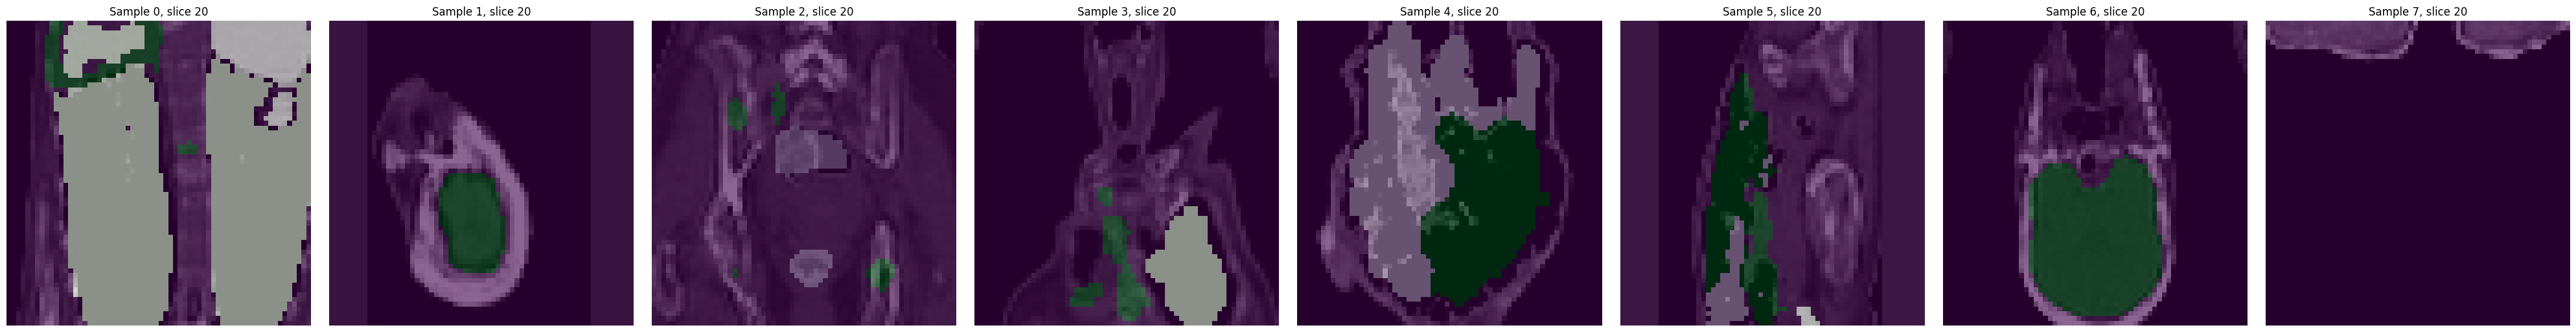

In [284]:
import matplotlib.pyplot as plt

z_idx = 20  # your chosen slice index
num_samples = len(data_all_composed)

fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))

# If num_samples == 1, axes is not a list, make it a list for consistency
if num_samples == 1:
    axes = [axes]

for sample_idx, ax in enumerate(axes):
    ct_slice    = data_all_composed[sample_idx]["image"][0, :, z_idx, :].cpu().numpy()
    label_slice = data_all_composed[sample_idx]["label"][0, :, z_idx, :].cpu().numpy()

    # Background CT
    ax.imshow(ct_slice.T, cmap="Greys_r", origin="lower")
    # Overlay label
    ax.imshow(label_slice.T, cmap="PRGn", origin="lower", alpha=0.6)

    ax.axis("off")
    ax.set_title(f"Sample {sample_idx}, slice {z_idx}")

plt.tight_layout()
plt.show()

In [286]:
import json
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    CropForegroundd, EnsureTyped,
)
from monai.data import Dataset

# ==== 1. Load json ====
json_path = "/Users/aryanneizehbaz/Downloads/center1_fold_1.json"
with open(json_path, "r") as f:
    fold = json.load(f)

# ==== 2. Build a list with ONLY CT + Seg paths ====
train_items = []
for it in fold["training"]:
    train_items.append({
        "image": it["image"][0],   # [CT, PET] -> keep ONLY CT
        "label": it["label"],
        "index": it["index"],
    })

val_items = []
for it in fold["validation"]:
    val_items.append({
        "image": it["image"][0],   # [CT, PET] -> keep ONLY CT
        "label": it["label"],
        "index": it["index"],
    })

all_items = train_items + val_items

# ==== 3. Define debug transforms (no RandCropByPosNegLabeld) ====
target_spacing = (4.0728, 4.0728, 3.0)

debug_transforms = Compose([
    LoadImaged(keys=["image", "label"], image_only=False),                      # load NIfTI
    EnsureChannelFirstd(keys=["image", "label"]),             # (H,W,D)->(C,H,W,D)
    Orientationd(keys=["image", "label"], axcodes="LPS"),     # common orientation
    Spacingd(
        keys=["image", "label"],
        pixdim=target_spacing,
        mode=("bilinear", "nearest"),                         # image, label
    ),
    CropForegroundd(
        keys=["image", "label"],
        source_key="label",
    ),
    EnsureTyped(keys=["image", "label"]),
])

# ==== 4. Create MONAI Dataset and iterate ====
ds = Dataset(data=all_items, transform=debug_transforms)

for i, d in enumerate(ds):
    img = d["image"]
    lab = d["label"]

    img_path = d["image_meta_dict"]["filename_or_obj"]
    lab_path = d["label_meta_dict"]["filename_or_obj"]

    print(f"THE DICTIONARY -------------> {d["image_meta_dict"]}")

    print(f"Case {i:02d} | index={d['index']}")
    print(f"  image: shape={img.shape}, path={img_path}")
    print(f"  label: shape={lab.shape}, path={lab_path}")
    print("-" * 80)

THE DICTIONARY -------------> {'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(0, dtype=int16), 'dim_info': array(0, dtype=uint8), 'dim': array([  3, 168, 168, 381,   1,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(64, dtype=int16), 'bitpix': array(64, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([1.    , 4.0728, 4.0728, 3.    , 0.    , 0.    , 0.    , 0.    ],
      dtype=float32), 'vox_offset': array(0., dtype=float32), 'scl_slope': array(nan, dtype=float32), 'scl_inter': array(nan, dtype=float32), 'slice_end': array(0, dtype=int16), 'slice_code': array(0, dtype=uint8), 'xyzt_units': array(10, dtype=uint8), 'cal_max': array(0., dtype=float32), 'cal_min': array(0., dtype=float32), 'slice_duration': array(0., dtype=float32), 'toffset': array(0., dtype=float32),

KeyboardInterrupt: 

--- TEST

In [322]:
import torch
import numpy as np

def _to_tensor(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x)
    return x.long()


def compute_segmentation_metrics(
    y_pred,
    y_true,
    num_classes=None,
    ignore_index=None,
    eps=1e-8,
):
    """
    y_pred, y_true: integer label maps, same shape: (H,W,D) or (N,H,W,D,...)
    """
    y_pred = _to_tensor(y_pred)
    y_true = _to_tensor(y_true)

    y_pred_flat = y_pred.view(-1)
    y_true_flat = y_true.view(-1)

    if num_classes is None:
        num_classes = int(max(y_pred_flat.max(), y_true_flat.max()).item() + 1)

    device = y_pred_flat.device

    tp = torch.zeros(num_classes, device=device, dtype=torch.float64)
    fp = torch.zeros(num_classes, device=device, dtype=torch.float64)
    fn = torch.zeros(num_classes, device=device, dtype=torch.float64)
    tn = torch.zeros(num_classes, device=device, dtype=torch.float64)

    for c in range(num_classes):
        pred_c = (y_pred_flat == c)
        true_c = (y_true_flat == c)

        tp[c] = (pred_c & true_c).sum()
        fp[c] = (pred_c & ~true_c).sum()
        fn[c] = (~pred_c & true_c).sum()
        tn[c] = (~pred_c & ~true_c).sum()

    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    iou = (tp + eps) / (tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    f1 = (2 * precision * recall + eps) / (precision + recall + eps)

    mask = torch.ones(num_classes, dtype=torch.bool, device=device)
    if ignore_index is not None and 0 <= ignore_index < num_classes:
        mask[ignore_index] = False

    metrics = {
        "per_class": {
            "tp": tp.cpu().numpy(),
            "fp": fp.cpu().numpy(),
            "fn": fn.cpu().numpy(),
            "tn": tn.cpu().numpy(),
            "dice": dice.cpu().numpy(),
            "iou": iou.cpu().numpy(),
            "precision": precision.cpu().numpy(),
            "recall": recall.cpu().numpy(),
            "f1": f1.cpu().numpy(),
        },
        "mean_over_classes": {
            "dice": dice[mask].mean().item(),
            "iou": iou[mask].mean().item(),
            "precision": precision[mask].mean().item(),
            "recall": recall[mask].mean().item(),
            "f1": f1[mask].mean().item(),
        },
    }

    return metrics


--- PRED -> LABEL

In [323]:
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    ResampleToMatchd,
    Compose,
)
from monai.data import MetaTensor

label_path = "/Users/aryanneizehbaz/Downloads/DATA_WITH_ORGAN_CLIPPED/Mask/Seg1_merged.seg_aligned.nii.gz"
pred_path  = "/Users/aryanneizehbaz/Downloads/CT1-res.nii_ep0150_b0.nii"  # your prediction

# 1) Load and align both to RAS
preprocess = Compose([
    LoadImaged(keys=["label", "pred"]),
    EnsureChannelFirstd(keys=["label", "pred"]),
    Orientationd(keys=["label", "pred"], axcodes="RAS"),
])

data = preprocess({"label": label_path, "pred": pred_path})

# 2) Resample prediction to EXACTLY match label (affine + spatial_shape)
#    mode="nearest" is critical for labels
resample = ResampleToMatchd(
    keys="pred",
    key_dst="label",
    mode="nearest",
)

data = resample(data)

label = data["label"]  # MetaTensor: [1, 512, 512, 457]
pred_resampled = data["pred"]  # MetaTensor: now [1, 512, 512, 457]

print(label.shape, pred_resampled.shape)  # should match


torch.Size([1, 512, 512, 457]) torch.Size([1, 512, 512, 457])


In [324]:
# remove channel dim
y_true = label[0].cpu().numpy()
y_pred = pred_resampled[0].cpu().numpy()

# choose your number of classes
num_classes = int(max(y_true.max(), y_pred.max()) + 1)

metrics = compute_segmentation_metrics(
    y_pred=y_pred,
    y_true=y_true,
    num_classes=num_classes,
    ignore_index=0,  # if 0 = background
)

print("Per-class Dice:", metrics["per_class"]["dice"])
print("Per-class IoU:", metrics["per_class"]["iou"])
print("Per-class Precision:", metrics["per_class"]["precision"])
print("Per-class Recall:", metrics["per_class"]["recall"])
print("Per-class F1:", metrics["per_class"]["f1"])
print("Mean Dice (fg only):", metrics["mean_over_classes"]["dice"])


Per-class Dice: [0.99413815 0.68846703 0.1815862  0.5802638  0.59039222 0.47031347
 0.71143704 0.06897859 0.03378081 0.04266552 0.71821465 0.00425028]
Per-class IoU: [0.98834461 0.52493307 0.09985967 0.40871241 0.41883439 0.30745742
 0.55211663 0.0357213  0.01718059 0.02179777 0.56032365 0.00212967]
Per-class Precision: [0.99404509 0.96798007 0.51150525 0.73473657 0.67543186 0.32126037
 0.85261205 0.28282828 0.31391277 0.0289849  0.86697966 0.00373095]
Per-class Recall: [0.99423122 0.53420926 0.11038699 0.47946082 0.52437167 0.87739086
 0.610372   0.03927916 0.01785089 0.08080456 0.61302561 0.00493758]
Per-class F1: [0.99413815 0.68846703 0.18158621 0.58026381 0.59039222 0.47031348
 0.71143704 0.06897862 0.03378084 0.04266561 0.71821465 0.00425143]
Mean Dice (fg only): 0.3718499652172742


--- LABEL -> PRED

In [326]:
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    ResampleToMatchd,
    Compose,
)
from monai.data import MetaTensor

label_path = "/Users/aryanneizehbaz/Downloads/DATA_WITH_ORGAN_CLIPPED/Mask/Seg1_merged.seg_aligned.nii.gz"
pred_path  = "/Users/aryanneizehbaz/Downloads/CT1-res.nii_ep0150_b0.nii"  # your prediction (already on low-res grid)

# 1) Load and align both to RAS
preprocess = Compose([
    LoadImaged(keys=["label", "pred"]),
    EnsureChannelFirstd(keys=["label", "pred"]),
    Orientationd(keys=["label", "pred"], axcodes="RAS"),
])

data = preprocess({"label": label_path, "pred": pred_path})

# 2) Resample LABEL to EXACTLY match PRED (spacing + affine + shape)
#    mode="nearest" is critical for LABELS
resample_label_to_pred = ResampleToMatchd(
    keys="label",
    key_dst="pred",   # <- match prediction
    mode="nearest",
)

data = resample_label_to_pred(data)

label_resampled = data["label"]  # [1, 168, 168, 381]
pred           = data["pred"]    # [1, 168, 168, 381]

print("label_resampled:", label_resampled.shape)
print("pred:", pred.shape)


label_resampled: torch.Size([1, 168, 168, 381])
pred: torch.Size([1, 168, 168, 381])


In [328]:
y_true = label_resampled[0].cpu().numpy()
y_pred = pred[0].cpu().numpy()

num_classes = int(max(y_true.max(), y_pred.max()) + 1)

metrics = compute_segmentation_metrics(
    y_pred=y_pred,
    y_true=y_true,
    num_classes=num_classes,
    ignore_index=0,   # if 0 is background
)

print("Per-class Dice:", metrics["per_class"]["dice"])
print("Per-class IoU:", metrics["per_class"]["iou"])
print("Per-class Precision:", metrics["per_class"]["precision"])
print("Per-class Recall:", metrics["per_class"]["recall"])
print("Per-class F1:", metrics["per_class"]["f1"])
print("Mean Dice (fg only):", metrics["mean_over_classes"]["dice"])

Per-class Dice: [0.99390925 0.69088545 0.18298415 0.6344197  0.5901014  0.46815248
 0.71286486 0.05958292 0.03109686 0.04212413 0.71705619 0.00515066]
Per-class IoU: [0.98789224 0.52775018 0.10070586 0.46457883 0.41854173 0.30561298
 0.5538384  0.03070624 0.015794   0.02151522 0.55891473 0.00258198]
Per-class Precision: [0.99379328 0.97471283 0.50661667 0.93096732 0.67192501 0.31857301
 0.85183605 0.2238806  0.29405034 0.02861056 0.8542654  0.00458505]
Per-class Recall: [0.99402524 0.5350762  0.11165662 0.48115423 0.5260426  0.88252331
 0.61287803 0.03436426 0.01641648 0.07983015 0.61782348 0.00587544]
Per-class F1: [0.99390925 0.69088545 0.18298416 0.6344197  0.5901014  0.46815248
 0.71286486 0.05958296 0.03109689 0.04212422 0.71705619 0.00515161]
Mean Dice (fg only): 0.3758562536065771


In [325]:
from monai.transforms import SaveImaged

# ... your existing code ...

data = resample(data)

label = data["label"]          # [1, 512, 512, 457]
pred_resampled = data["pred"]  # [1, 512, 512, 457]

# 3) Save resampled prediction as NIfTI
save_pred = SaveImaged(
    keys="pred",
    meta_keys="pred_meta_dict",   # created by LoadImaged
    output_dir="/Users/aryanneizehbaz/Downloads/RESAMPLED_PRED",
    output_postfix="resampled",   # e.g. CT1-res.nii_ep0150_b0_resampled.nii.gz
    separate_folder=False,
    resample=False,               # VERY IMPORTANT: already resampled!
)

data = save_pred(data)

print("Saved to:", data["pred_meta_dict"]["filename_or_obj"])


2025-11-17 19:54:16,759 INFO image_writer.py:197 - writing: /Users/aryanneizehbaz/Downloads/RESAMPLED_PRED/CT1-res.nii_ep0150_b0_resampled.nii.gz


KeyError: 'pred_meta_dict'